# Project：韓文新聞分類

這個專案的資料修改自 [YNAT](https://klue-benchmark.com/tasks/66/overview/description) 資料集，藉由韓文的新聞標題，來判斷該新聞的主題分類

訓練資料集（`train.csv`） 、驗證資料集（`val.csv`）、測試資料集（`test.csv`）分別有 40,000、5,000、5,000 筆新聞的資料，每個資料集都包含以下欄位：
- `id`: 該新聞的 ID
- `title`: 該新聞的標題，例如 `G20 때 홍콩 문제 알리자…홍콩 시민들 릴레이 시위 예고`
- `topic`: 該新聞的主題，例如 `사회`

`tppic` 有 7 種可能：
- `IT과학`: 資訊與科技
- `경제`: 經濟
- `사회`: 社會
- `생활문화`: 生活文化
- `세계`: 國際
- `스포츠`: 運動
- `정치`: 政治

目標是要用訓練資料集來訓練一個模型，輸入一個新聞標題，輸出一個預測的主題（上述 7 種的其中一個），並且用預測測試集來計算準確率 (Accuracy)。

Outlines
- 實作的流程包含：簡易的資料分析、資料前處理、模型訓練與驗證、精準度評估
- 使用 ScikitLearn 的 `accuracy_score()` 作為 accuracy 的計算
- Futureworks

# Import

In [ ]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import shutil

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

tf.get_logger().setLevel('ERROR')

Version:  2.13.1
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


# 思路及流程


此為純文字分類問題。

Given 大約 1~2 個晚上的 time constraint，比較有效的方式是找一個 pre-trained language model，該模型必須能 output 韓文的 sentence embedding，接著 apply transfer learning 去訓練分類的 task。 詳細流程如下：

*   需求理解
*   資料分析 (EDA)
*   資料前處理 (Preprocess)
*   Proof of Concept (設計小模型，MVP 概念驗證、快速迭代)
*   Model Design and Training
*   Evaluation

### TL;DR;

Best model，evaluation 數據如下:
- accuracy: 0.7910
- f1_macro: 0.7916



# 需求理解






## 定義問題

Given koerean news title x, output it's category. (There're 7 categories in total)

## 制定 evaluation metric

分類問題大多會以 accuracy 作為評量 model 好壞的標準。 不過仔細看了 YNAT dataset 後，官方的比賽也有以 marco F1-Score 作為衡量標準的方式。 詳細說明如下：

*   F1 score 是 percision 和 recall 的幾何平均
*   percision: 在所有預測為 positive 的結果中，有多少比例為 true positive
*   recall: 模型預測出的 true positive 佔資料的真實 true positive 的比例
*   模型同時有高的 percision 和 recall，才能得到高的 F1 score
*   Marco F1 score 是計算完 class-wise 的 F1 Score 後，再取平均

In [ ]:
class F1Macro(tf.keras.metrics.F1Score):

    def __init__(self, name='f1_macro', **kwargs):
        super().__init__(name=name, average = 'macro')

    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_test, y_pred)

    def result(self):
        return super().result()

# Acquire Data

In [ ]:
# Load training data set.
train_df = pd.read_csv("https://github.com/lush93gh/korean_news_topic_classification/raw/refs/heads/main/train.csv")
# Load validation data set.
val_df = pd.read_csv("https://github.com/lush93gh/korean_news_topic_classification/raw/refs/heads/main/val.csv")
# Load testing data set.
test_df = pd.read_csv("test")

# Analyze by describing data

查看資料

In [ ]:
print("Training data (first 10 samples):")
print(train_df.head(10))
print("Validation data (first 10 samples):")
print(val_df.head(10))
print("Testing data (first 10 samples):")
print(test_df.head(10))

Training data (first 10 samples):
   id                             title topic
0   0                    제6회 국제주택도시금융포럼    사회
1   1           현대상선 용선료 협상 타결돼도 산 넘어 산    사회
2   2          우주 풀어야 할 숙제 많은 곳…95%는 몰라  IT과학
3   3  G20 때 홍콩 문제 알리자…홍콩 시민들 릴레이 시위 예고    세계
4   4    2분기 전국 아파트값 5년만에 최대폭 하락…서울은 올라    경제
5   5                     NBIoT 기술시연 행사  IT과학
6   6         부산항 북항 크루즈 부두 넓힌다…대형선박 수용    경제
7   7  최장신 거포 러츠의 압도적 높이…GS칼텍스 고공 배구...   스포츠
8   8     김윤식 신협중앙회장 전국 순회로 615개 이사장 만나    사회
9   9        황총리 국방과학연구소 방문…국가안보 역할 해달라    정치
Validation data (first 10 samples):
      id                              title topic
0  40000  여야 개헌 기싸움 팽팽…정의장4개 교섭단체 원내대표 첫 회동    정치
1  40001       北 조선중앙TV 당대회 김정은 총화보고 녹화방송3보    정치
2  40002       축구신 메시 4년 만에 라리가 최고골잡이 복귀 눈앞   스포츠
3  40003         제임스 떠난 클리블랜드 속절없는 개막 후 4연패   스포츠
4  40004      유희관 내 친화력으로 린드블럼·후랭코프 적응 도울 것   스포츠
5  40005                  눈길 빙판길 추위에 출근길 비상  생활문화
6  40006  영상 검찰 김학의 뇌물의혹 강제수사 착수…자택·별장 압수수색    사회
7  40007   서울시 4일 민주노총 집

檢查資料型態

In [ ]:
train_df.info()
print('_'*40)
val_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      40000 non-null  int64 
 1   title   40000 non-null  object
 2   topic   40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5000 non-null   int64 
 1   title   5000 non-null   object
 2   topic   5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5000 non-null   int64 
 1   title   5000 non-null

看一下資料分佈，每個新聞 title 都是不同的

In [ ]:
train_df.describe(include=['O'])

,title,topic
count,40000,40000
unique,40000,7
top,제6회 국제주택도시금융포럼,세계
freq,1,6678


# Preporcess Data

前處理重點：

- 移除 `title` 的標點符號：因為新聞標題中的標點符號，對於這篇新聞是哪一類型的影響應該是小的。 所以這邊做移除標點符號的處理。
- 將 `topic` 轉換為數字，以利模型做分類
- 其餘事項如 tokenization, vectorization 等，均交由 embedding model 來處理。

* 這邊實測的結果是，後續步驟所採用的幾個 embedding model，內建文本的前處理。 即便不移除標點符號，對 embedding 的影響也偏低。

(有無前處理的差異，可以計算兩種方式得出的 embedding 之 cosine simmarility，在此處不特別列出)

```
print(np.matmul(raw_embeds, np.transpose(processed_embeds)))
```

In [ ]:
import string
def remove_punctuation(input_string):
    translator = str.maketrans('', '', string.punctuation)

    no_punct = input_string.translate(translator)
    return no_punct

remove_punctuation('최장신 거포 러츠의 압도적 높이…GS칼텍스 고공 배구...')

In [ ]:
train_df['title'] = train_df['title'].map(remove_punctuation)
val_df['title'] = val_df['title'].map(remove_punctuation)
test_df['title'] = test_df['title'].map(remove_punctuation)

train_df['title'].head()

0                      제6회 국제주택도시금융포럼
1             현대상선 용선료 협상 타결돼도 산 넘어 산
2             우주 풀어야 할 숙제 많은 곳…95는 몰라
3    G20 때 홍콩 문제 알리자…홍콩 시민들 릴레이 시위 예고
4      2분기 전국 아파트값 5년만에 최대폭 하락…서울은 올라
Name: title, dtype: object

In [ ]:
label2idx = {"정치": 0, "경제": 1, "사회": 2, "생활문화": 3, "세계": 4, "IT과학": 5, "스포츠": 6}

train_df['topic'] = train_df['topic'].map(label2idx)
val_df['topic'] = val_df['topic'].map(label2idx)
test_df['topic'] = test_df['topic'].map(label2idx)

train_df['topic'].head()

0    2
1    2
2    5
3    4
4    1
Name: topic, dtype: int64

In [ ]:
train_features = tf.convert_to_tensor(train_df['title'],dtype=tf.string)
train_target = tf.convert_to_tensor(train_df['topic'], dtype=tf.int64)
train_data = tf.data.Dataset.from_tensor_slices((train_df['title'], train_df['topic']))
train_data = train_data.cache().shuffle(40000).batch(64).prefetch(buffer_size=AUTOTUNE)

In [ ]:
val_features = tf.convert_to_tensor(val_df['title'], dtype=tf.string)
val_target = tf.convert_to_tensor(val_df['topic'], dtype=tf.int64)
validation_data = tf.data.Dataset.from_tensor_slices((val_df['title'], val_df['topic']))
validation_data = validation_data.cache().batch(512).prefetch(buffer_size=AUTOTUNE)

In [ ]:
test_features = tf.convert_to_tensor(test_df['title'],dtype=tf.string)
test_target = tf.convert_to_tensor(test_df['topic'], dtype=tf.int64)
test_data = tf.data.Dataset.from_tensor_slices((test_df['title'], test_df['topic']))
test_data = test_data.cache().batch(5000).prefetch(buffer_size=AUTOTUNE)

y_test = tf.one_hot(test_df['topic'], 7)

# Proof of Concept

POC 階段選了一個比較輕量的 embedding model： Google NNLM

一開始選 `ko-dim50-with-normalization` 的 model，該模型可以將文字轉換為 1D-50 維的 vector。 embedding model 本身是由 Korean Google News 15B corpus 訓練而成。 非常適合本次分類的 task。

之後實驗將 base model 改為 `ko-dim128-with-normalization`，發現準確率有顯著提升 (約 5%)。 **可見找到好的 sentence embedding 對於訓練分類模型是有顯著效益的**。 因為這邊的 transfer learning 是 given 一個 sentence embedding，分類模型要去 maximize 分類正確的 likelihood。 所以作為 prior 的 embedding 越能精準表達 latent space 的 manifold 越好。

順帶一提，有 normalization 版本的 nnlm model，會對 text 做前處理。包含移除標點符號、根據空格斷詞等。

In [ ]:
embedding = "https://www.kaggle.com/models/google/nnlm/TensorFlow2/ko-dim128-with-normalization/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=False)

## 模型設計迭代

因為 base model 已經能產生不錯的 sentence embedding，這邊要迭代驗證的項目如下：

1.   Classifier 的設計
2.   Dropout layer 的選擇
3.   activation function 的選擇
4.   Normalization Layer 的設計

衡量的方式是計算 test dataset 的 accuracy。

** 抱歉，因為過程中忘記紀錄每一種方法的數據了。 POC 階段得到最好的結果如底下 code block。

### 1. Classifier 的設計

將 sentence embedding 映射(map)成新聞分類的 logits，是 classifier 主要的任務。 這邊探網路討架構的設計。 最終版本如以下 code block。 嘗試過的架構有：

1. 直接進行分類 (feed-forward to 7 neurons)
2. 過一層 hidden layer (64 neurons)，再進行分類 (feed-forward to 7 neurons)
3. 逐步增加 hidden layer 的數量，每層遞減。
4. 以 RNN 作為 decoder
5. 以 Transformer 作為 Decoder

其中， 4 和 5 會讓訓練變慢，成效也比目前最好的架構差很多。 反覆嘗試 1~3 的方式後，發現以 2 的倍數逐層遞減 number of neurons，會得到最高的準確率。

### 2. Dropout layer 的選擇

將 dropout layer 加在 embedding layer 後，可以隨機隱藏一些 features，讓 Classifier 的 input 減少對 embedding features 的依賴，藉此達到較好的 generalization。

經測量後，128 維度的 embeddings，採用 25% 的 dropout rate 能得到最好的 test accuracy。

### 3. Activation function 的選擇

這邊實測了 activation function 對 accuracy 的影響。 發現 Swish(silu) Activation 相較於 ReLu，能提升 1% 的 accuracy。

測試過的 activation functions：

- relu
- softplus
- selu
- leaky_relu
- silu
- gelu
- mish

### 4. Normalization Layer 的設計

嘗試在每一層 Dense layer 後，加上 Normalization Layer，使訓練更穩定。 目前試過 BatchNormalization 和 LayerNormalization。 兩種方式比起不 apply normalization，均無法得出更好的 accuracy。


### 最終得出的模型如下






In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(64, activation='silu'))
model.add(tf.keras.layers.Dense(32, activation='silu'))
model.add(tf.keras.layers.Dense(16, activation='silu'))
model.add(tf.keras.layers.Dense(7))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               116962560 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 7)                 119       
                                                                 
Total params: 116973543 (446.22 MB)
Trainable params: 10

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                  F1Macro()
    ])

In [ ]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/poc.weights.h5'
model.load_weights(checkpoint_filepath)

In [ ]:
def test_metric():
  print()
  results = model.evaluate(test_data, verbose=0)

  for name, value in zip(model.metrics_names, results):
    print("%s: %.4f" % (name, value))

cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda a, b: test_metric())
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
csv_logger = tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/poc.training.log')
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/poc.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Training

In [ ]:
history = model.fit(train_data,
                    epochs=100,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb])

Epoch 1/100
613/625 [============================>.] - ETA: 0s - loss: 1.2190 - accuracy: 0.5671
loss: 0.9599
accuracy: 0.6686
625/625 [==============================] - 6s 9ms/step - loss: 1.2148 - accuracy: 0.5684 - val_loss: 0.9553 - val_accuracy: 0.6592
Epoch 2/100
604/625 [===========================>..] - ETA: 0s - loss: 0.9837 - accuracy: 0.6495
loss: 0.9132
accuracy: 0.6818
625/625 [==============================] - 3s 5ms/step - loss: 0.9842 - accuracy: 0.6493 - val_loss: 0.9056 - val_accuracy: 0.6850
Epoch 3/100
605/625 [============================>.] - ETA: 0s - loss: 0.9541 - accuracy: 0.6606
loss: 0.8974
accuracy: 0.6892
625/625 [==============================] - 5s 8ms/step - loss: 0.9539 - accuracy: 0.6611 - val_loss: 0.8925 - val_accuracy: 0.6888
Epoch 4/100
625/625 [==============================] - ETA: 0s - loss: 0.9457 - accuracy: 0.6643
loss: 0.8881
accuracy: 0.6906
625/625 [==============================] - 2s 3ms/step - loss: 0.9457 - accuracy: 0.6643 - val_loss

## Evaluation


In [ ]:
test_metric()


loss: 0.8208
accuracy: 0.7068
f1_macro: 0.7044


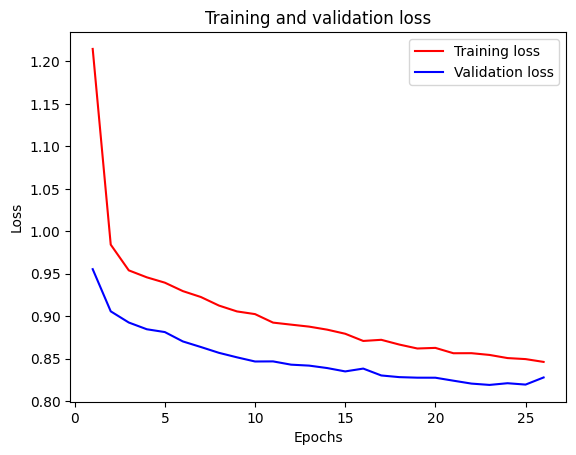

In [ ]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

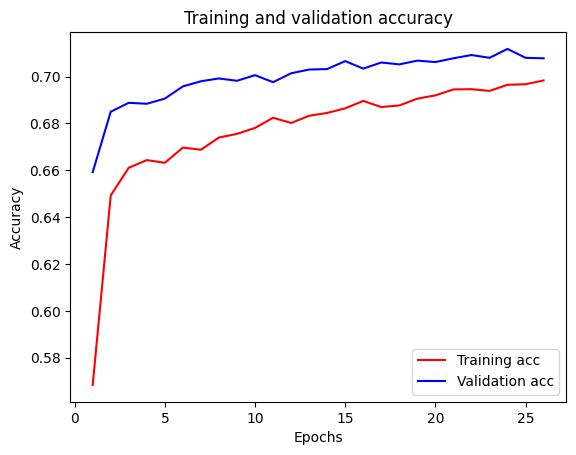

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Model Design and Training

經過 POC 後，選用 Google `universal-sentence-encoder` 作為 base model。

這個模型是基於 deep averaging network (DAN) encoder，由 16 種語言 pretrain。 並且會輸出 1D - 512 維度的 embedding。

比起使用 pre-trained BERT，以此模型做為 base model，在 transfer learning 的速度會快很多。

In [ ]:
embedding = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/multilingual-large/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=False)

模型的設計和 POC 階段相似，使用多層 feed forward layer 作為 classifier。 因為 classifier network 的 parameter 較多。

這邊將 dropout rate 設定大一點。

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='silu'))
model.add(tf.keras.layers.Dense(128, activation='silu'))
model.add(tf.keras.layers.Dense(64, activation='silu'))
model.add(tf.keras.layers.Dense(32, activation='silu'))
model.add(tf.keras.layers.Dense(16, activation='silu'))
model.add(tf.keras.layers.Dense(7))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               85213184  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)               

In [ ]:
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/checkpoint.weights5.h5'
model.load_weights(checkpoint_filepath)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                  F1Macro()
    ])

In [ ]:
cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda a, b: test_metric())
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
csv_logger = tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/training2.log')
checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/checkpoint.weights6.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Training

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.6476
loss: 0.7163
accuracy: 0.7540
625/625 [==============================] - 581s 905ms/step - loss: 0.9753 - accuracy: 0.6476 - val_loss: 0.7243 - val_accuracy: 0.7520
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.7419
loss: 0.6776
accuracy: 0.7628
625/625 [==============================] - 519s 831ms/step - loss: 0.7444 - accuracy: 0.7419 - val_loss: 0.6888 - val_accuracy: 0.7606
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.7489
loss: 0.6739
accuracy: 0.7656
625/625 [==============================] - 498s 797ms/step - loss: 0.7183 - accuracy: 0.7489 - val_loss: 0.6732 - val_accuracy: 0.7656
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.7495
loss: 0.6602
accuracy: 0.7740
625/625 [==============================] - 486s 778ms/step - loss: 0.7060 - accuracy: 0.749

In [ ]:
history2 = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7627
loss: 0.6236
accuracy: 0.7756
625/625 [==============================] - 949s 1s/step - loss: 0.6584 - accuracy: 0.7627 - val_loss: 0.6326 - val_accuracy: 0.7790
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.7667
loss: 0.6238
accuracy: 0.7766
625/625 [==============================] - 955s 2s/step - loss: 0.6474 - accuracy: 0.7667 - val_loss: 0.6198 - val_accuracy: 0.7824
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.7715
loss: 0.6137
accuracy: 0.7852
625/625 [==============================] - 947s 2s/step - loss: 0.6364 - accuracy: 0.7715 - val_loss: 0.6252 - val_accuracy: 0.7802
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.7761

In [ ]:
history3 = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb, csv_logger])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.7730
loss: 0.6202
accuracy: 0.7822
625/625 [==============================] - 944s 1s/step - loss: 0.6377 - accuracy: 0.7730 - val_loss: 0.6245 - val_accuracy: 0.7814
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.7729
loss: 0.6181
accuracy: 0.7828
625/625 [==============================] - 966s 2s/step - loss: 0.6283 - accuracy: 0.7729 - val_loss: 0.6188 - val_accuracy: 0.7784
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7784
loss: 0.6167
accuracy: 0.7844
625/625 [==============================] - 961s 2s/step - loss: 0.6165 - accuracy: 0.7784 - val_loss: 0.6126 - val_accuracy: 0.7856
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.6071 - accuracy: 0.7801
loss: 0.6214
accuracy: 0.7800
625/625 [==============================] - 1012s 2s/step - loss: 0.6071 - accuracy: 0.7801 - val_los

In [ ]:
history4 = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb, csv_logger])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7918
loss: 0.6028
accuracy: 0.7840
625/625 [==============================] - 1015s 2s/step - loss: 0.5672 - accuracy: 0.7918 - val_loss: 0.6017 - val_accuracy: 0.7922
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7970
loss: 0.5999
accuracy: 0.7866
625/625 [==============================] - 962s 2s/step - loss: 0.5577 - accuracy: 0.7970 - val_loss: 0.6021 - val_accuracy: 0.7914
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7976
loss: 0.6058
accuracy: 0.7838
625/625 [==============================] - 863s 1s/step - loss: 0.5503 - accuracy: 0.7976 - val_loss: 0.6114 - val_accuracy: 0.7826
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8005
loss: 0.6229
accuracy: 0.7814
625/625 [==============================] - 859s 1s/step - loss: 0.5443 - accuracy: 0.8005 - val_los

In [ ]:
history5 = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7800
loss: 0.6036
accuracy: 0.7860
625/625 [==============================] - 1065s 2s/step - loss: 0.6049 - accuracy: 0.7800 - val_loss: 0.6073 - val_accuracy: 0.7874
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7819
loss: 0.6004
accuracy: 0.7872
625/625 [==============================] - 891s 1s/step - loss: 0.6001 - accuracy: 0.7819 - val_loss: 0.5983 - val_accuracy: 0.7886
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.7842
loss: 0.5998
accuracy: 0.7898
625/625 [==============================] - 884s 1s/step - loss: 0.5959 - accuracy: 0.7842 - val_loss: 0.5996 - val_accuracy: 0.7884
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.7862
loss: 0.6001
accuracy: 0.7890
625/625 [==============================] - 906s 1s/step - loss: 0.5875 - accuracy: 0.7862 - val_los

In [ ]:
history6 = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, early_stopping, cb])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.7642
loss: 0.6123
accuracy: 0.7844
625/625 [==============================] - 1007s 2s/step - loss: 0.6554 - accuracy: 0.7642 - val_loss: 0.6108 - val_accuracy: 0.7798
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.7674
loss: 0.6050
accuracy: 0.7840
625/625 [==============================] - 890s 1s/step - loss: 0.6456 - accuracy: 0.7674 - val_loss: 0.6057 - val_accuracy: 0.7852
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.7667
loss: 0.5994
accuracy: 0.7900
625/625 [==============================] - 961s 2s/step - loss: 0.6459 - accuracy: 0.7667 - val_loss: 0.5968 - val_accuracy: 0.7864
Epoch 4/10
  2/625 [..............................] - ETA: 9:13 - loss: 0.5660 - accuracy: 0.8203

KeyboardInterrupt: 

## Evaluation

In [ ]:
test_metric()


loss: 0.5991
accuracy: 0.7910
f1_macro: 0.7916


# 改進方式

由上面的實驗可以推斷，sentence embedding 對 classifier 有顯著的影響。 而一個好的 feature extractor 通常能 output 較好的 embedding。

改進的方法可以用 Pre-Trained BERT 作為 base model。 以下的 code blocks 使用 BERT 來作為 base model。 時間因素，就沒有跑完實驗了。

*   如果使用 GPT 作為 base model，相信能得到更好的 sentence embedding，也能更有效做分類。
*   Finetune base model 或許能進一步提升 accuracy



In [ ]:
tfhub_handle_preprocess = "https://kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/cmlm-multilingual-preprocess/2"
tfhub_handle_encoder = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/cmlm-multilingual-base/1"

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(384, activation='silu')(net)
  net = tf.keras.layers.Dense(192, activation='silu')(net)
  net = tf.keras.layers.Dense(96, activation='silu')(net)
  net = tf.keras.layers.Dense(48, activation='silu')(net)
  net = tf.keras.layers.Dense(24, activation='silu')(net)
  net = tf.keras.layers.Dense(12, activation='silu')(net)
  net = tf.keras.layers.Dense(7, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [ ]:
text_test = ['제6회 국제주택도시금융포럼']
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.47201183 0.5146386  0.56529415 0.50055265 0.43769878 0.4405658
  0.4927307 ]], shape=(1, 7), dtype=float32)


In [ ]:
classifier_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
                  F1Macro()
    ])

In [ ]:
history = classifier_model.fit(train_data,
                    epochs=5,
                    validation_data=validation_data,
                    verbose=1)

In [ ]:
test_metric()